# Calculating Customer Lifetime Value (CLV) 

## Step 1-Understand the Dataset

#### Name : Rofin Andonissamy                                                                                                      




In [1]:
import pandas as pd
import matplotlib.pyplot as plt

#Read the CSV file as a data frame and perform datatype normalization 
df = pd.read_csv("HW1 clv_transactions-1.csv",parse_dates=['TransactionDate'],dtype={'TransactionID':int,'CustomerID':int,'Amount':float})

#Print any rows with missing values- There isn't any missing values
print("Rows with missing values: " , df.isnull().any().any())

#Range of date
print("Range of Dates: " , df['TransactionDate'].min().date()," to ",df['TransactionDate'].max().date())

#Number of Unique customers
print("number of unique customers: ",df['CustomerID'].nunique())

#Descriptive Statistics
print("Minimum : {}, Maximum : {}, Variance : {}, Standard deviation: {}".format(df['Amount'].min(),df['Amount'].max(),round(df['Amount'].var(),2),round(df['Amount'].std(),2)))

#Plot the transaction amount
df1 = df.copy()
df1.groupby(df1.TransactionDate.dt.year).agg({'Amount':'sum'}).plot()
plt.title('Transaction History')
plt.xlabel('Year')
plt.ylabel('Amount')
plt.show()

Rows with missing values:  False
Range of Dates:  2010-01-04  to  2015-12-31
number of unique customers:  1000
Minimum : -1.0, Maximum : 2033.0, Variance : 1499.54, Standard deviation: 38.72


<Figure size 640x480 with 1 Axes>

## Step 2-Explore the dataset

##### 1. Are there any outliers?
yes. Looking at the boxplot there seems to be extreme outliers,value distribution of the outlier seems so small and the outliers are at huge intervals. Hence the boxplot could not make much sense 
##### 2. If so how would you treat them?
values that are away from 1.5 to 3 times the interquartile range could be outliers and the values beyond this threshold are definitely outliers. Hence, for the transaction which exceeds the above mentioned threshold, the amount value is been made zero('0').  

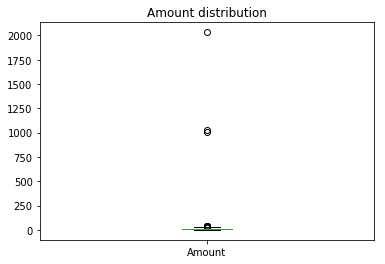

From the boxplot we could not make much sense, this is due to irregular distribution might be influenced by extreme outliers
Let us try eliminating the outliers using interquartile range
possible outliers are values less than -21.83 and greater than 36.83 by IQR


In [463]:
#Step 2
df['Amount'].plot(kind='box')
plt.title('Amount distribution')
plt.show()

print('From the boxplot we could not make much sense, this is due to irregular distribution might be influenced by extreme outliers')
print('Let us try eliminating the outliers using interquartile range')

mean = df['Amount'].mean()
std  = df['Amount'].std()
#Determine the quartiles
q1 = df['Amount'].quantile(0.25)
q3 = df['Amount'].quantile(0.75)
iqr = (q3-q1)

#vcompute the minimum and maximum threshold
min_thres = round((q1-(3 * iqr)),2)
max_thres = round((q3+(3 * iqr)),2)
print('possible outliers are values less than {} and greater than {} by IQR'.format(min_thres,max_thres))


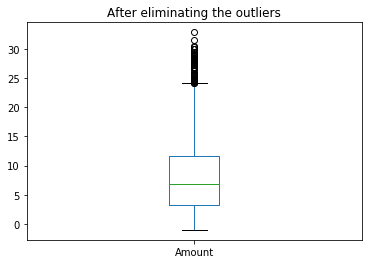

In [464]:
# Eliminate the outliers and plot the boxplot
#clean_data = df[(df.Amount >= min_thres) & (df.Amount <= max_thres)]
clean_data = df.copy(deep=True)
clean_data.loc[clean_data['Amount'] <= min_thres,'Amount'] = 0
clean_data.loc[clean_data['Amount'] >= max_thres,'Amount']= 0
clean_data['Amount'].plot(kind='box')
plt.title("After eliminating the outliers")
plt.show()

# Step 3 - Determine origin year of customers
##### 1. Can you write Python scripts to assign appropriates origin year to all customers?
yes. The below script segments the customer based on the orgin and creates appropriate lists containing the customers, who were acquired in the particular year 

cust_2010 - List of customers with 2010 as orgin
cust_2011 - List of customers with 2011 as orgin
cust_2012 - List of customers with 2012 as orgin
cust_2013 - List of customers with 2013 as orgin
cust_2014 - List of customers with 2014 as orgin
cust_2015 - List of customers with 2015 as orgin

In [465]:
#Customer Segmentation
import datetime as dt
dseg = clean_data.copy(deep=True)
dseg['trans_year']=pd.to_datetime(dseg[('TransactionDate')], format='%m/%d/%Y').dt.year

dseg.sort_values(by=['CustomerID','trans_year'])
cust_seg_idx = dseg.groupby('CustomerID')['trans_year'].idxmin()
cust_seg = dseg.loc[cust_seg_idx]

#segment the customer
cust_2010 = cust_seg[cust_seg.trans_year == 2010].CustomerID 
cust_2011 = cust_seg[cust_seg.trans_year == 2011].CustomerID
cust_2012 = cust_seg[cust_seg.trans_year == 2012].CustomerID
cust_2013 = cust_seg[cust_seg.trans_year == 2013].CustomerID
cust_2014 = cust_seg[cust_seg.trans_year == 2014].CustomerID
cust_2015 = cust_seg[cust_seg.trans_year == 2015].CustomerID

print('Customer Acquired in 2010')
print(cust_2010)
print('Customer Acquired in 2011')
print(cust_2011)
print('Customer Acquired in 2012')
print(cust_2012)
print('Customer Acquired in 2013')
print(cust_2013)
print('Customer Acquired in 2014')
print(cust_2014)
print('Customer Acquired in 2015')
print(cust_2015)
#dfwide= df.pivot(index= 'CustomerID', value=df.TransactionDate.dt.year)
#print(dfwide) 

Customer Acquired in 2010
28         9
34        10
84        19
95        22
144       36
168       42
185       48
221       57
226       58
239       60
308       78
339       86
368       94
404       98
431      103
453      109
469      114
488      117
511      122
527      127
553      135
600      152
613      155
618      156
630      161
669      174
674      175
689      180
695      182
731      189
        ... 
3587     870
3598     873
3602     874
3639     884
3647     885
3655     886
3686     895
3696     898
3704     901
3705     902
3710     903
3741     907
3765     912
3792     920
3804     922
3834     930
3880     940
3896     943
3923     947
3953     956
3989     961
4041     972
4084     980
4103     984
4105     985
4118     988
4119     989
4126     990
4155     998
4166    1000
Name: CustomerID, Length: 172, dtype: int32
Customer Acquired in 2011
23        7
39       12
45       13
117      30
161      39
163      41
213      56
234      59
275      72
284

# Step 4: Calculate cumulative transaction amounts

In [466]:
tr_data = dseg.copy(deep=True)
tr_data.sort_values(by=['CustomerID','trans_year'])

# Capture the transaction detail of customers aquired in different period
cus_2010_tr = tr_data[tr_data.CustomerID.isin(cust_2010)] 
cus_2011_tr = tr_data[tr_data.CustomerID.isin(cust_2011)] 
cus_2012_tr = tr_data[tr_data.CustomerID.isin(cust_2012)] 
cus_2013_tr = tr_data[tr_data.CustomerID.isin(cust_2013)] 
cus_2014_tr = tr_data[tr_data.CustomerID.isin(cust_2014)]
cus_2015_tr = tr_data[tr_data.CustomerID.isin(cust_2015)] 

#Sort the transaction dataset
cus_2010_tr.sort_values(by=['CustomerID','trans_year'])
cus_2011_tr.sort_values(by=['CustomerID','trans_year'])
cus_2012_tr.sort_values(by=['CustomerID','trans_year'])
cus_2013_tr.sort_values(by=['CustomerID','trans_year'])
cus_2014_tr.sort_values(by=['CustomerID','trans_year'])
cus_2015_tr.sort_values(by=['CustomerID','trans_year'])

#Calcualte the cumulative transaction amount for each segment of customer
cum_2010 = cus_2010_tr.groupby('trans_year')['Amount'].sum()
cum_2010 = cum_2010.cumsum()
cum_2011 = cus_2011_tr.groupby('trans_year')['Amount'].sum()
cum_2011 = cum_2011.cumsum()
cum_2012 = cus_2012_tr.groupby('trans_year')['Amount'].sum()
cum_2012 = cum_2012.cumsum()
cum_2013 = cus_2013_tr.groupby('trans_year')['Amount'].sum()
cum_2013 = cum_2013.cumsum()
cum_2014 = cus_2014_tr.groupby('trans_year')['Amount'].sum()
cum_2014 = cum_2014.cumsum()
cum_2015 = cus_2015_tr.groupby('trans_year')['Amount'].sum()
cum_2015 = cum_2015.cumsum()

import numpy as np
orgin = ['2010-01-01 - 2010-12-31']
cum_tr_10 = np.array(cum_2010)
cum_tr_11 = np.array(cum_2011)
cum_tr_12 = np.array(cum_2012)
cum_tr_13 = np.array(cum_2013)
cum_tr_14 = np.array(cum_2014)
cum_tr_15 = np.array(cum_2015)

# Create the triangle
amount = pd.DataFrame({'Orgin':['2010-01-01 - 2010-12-31','2011-01-01 - 2011-12-31',
                                '2012-01-01 - 2012-12-31','2013-01-01 - 2013-12-31',
                                '2014-01-01 - 2014-12-31','2015-01-01 - 2015-12-31'],
                        '12':[cum_tr_10[0],cum_tr_11[0],cum_tr_12[0],cum_tr_13[0],
                              cum_tr_14[0],cum_tr_15[0]],
                        '24':[cum_tr_10[1],cum_tr_11[1],cum_tr_12[1],cum_tr_13[1],
                              cum_tr_14[1],''],
                        '36':[cum_tr_10[2],cum_tr_11[2],cum_tr_12[2],cum_tr_13[2],
                              '',''],
                        '48':[cum_tr_10[3],cum_tr_11[3],cum_tr_12[3],'',
                              '',''],
                        '60':[cum_tr_10[4],cum_tr_11[4],'','',
                              '',''],
                        '72':[cum_tr_10[5],'','','',
                              '','']

})    
amount

,Orgin,12,24,36,48,60,72
0,2010-01-01 - 2010-12-31,2259.67,3614.78,5274.81,6632.37,7930.69,8964.49
1,2011-01-01 - 2011-12-31,2201.52,3746.42,5462.69,6699.81,7821.67,
2,2012-01-01 - 2012-12-31,2116.60,3763.41,5115.58,6390.57,,
3,2013-01-01 - 2013-12-31,2179.85,3608.81,5226.75,,,
4,2014-01-01 - 2014-12-31,1830.85,3262.05,,,,
5,2015-01-01 - 2015-12-31,1912.17,,,,,


# Step 5: Calculate cumulative transaction amounts

In [435]:
customer  = pd.DataFrame({'Orgin':['2010-01-01 - 2010-12-31','2011-01-01 - 2011-12-31',
                                '2012-01-01 - 2012-12-31','2013-01-01 - 2013-12-31',
                                '2014-01-01 - 2014-12-31','2015-01-01 - 2015-12-31'],
                        '12':[cust_2010.count(),cust_2011.count(),cust_2012.count(),cust_2013.count(),
                              cust_2014.count(),cust_2015.count()],
                        '24':[cust_2010.count(),cust_2011.count(),cust_2012.count(),cust_2013.count(),
                              cust_2014.count(),''],
                        '36':[cust_2010.count(),cust_2011.count(),cust_2012.count(),cust_2013.count(),
                              '',''],
                        '48':[cust_2010.count(),cust_2011.count(),cust_2012.count(),'',
                              '',''],
                        '60':[cust_2010.count(),cust_2011.count(),'','',
                              '',''],
                        '72':[cust_2010.count(),'','','',
                              '','']

})    
customer

,Orgin,12,24,36,48,60,72
0,2010-01-01 - 2010-12-31,172,172,172,172,172,172
1,2011-01-01 - 2011-12-31,171,171,171,171,171,
2,2012-01-01 - 2012-12-31,162,162,162,162,,
3,2013-01-01 - 2013-12-31,180,180,180,,,
4,2014-01-01 - 2014-12-31,155,155,,,,
5,2015-01-01 - 2015-12-31,160,,,,,


## Step 6: Historic CLV

In [437]:
clv_10 = cum_tr_10/cust_2010.count()
clv_11 = cum_tr_11/cust_2011.count()
clv_12 = cum_tr_12/cust_2012.count()
clv_13 = cum_tr_13/cust_2013.count()
clv_14 = cum_tr_14/cust_2013.count()
clv_15 = cum_tr_15/cust_2014.count()

clv_10= np.round(clv_10,2)
clv_11= np.round(clv_11,2)
clv_12= np.round(clv_12,2)
clv_13= np.round(clv_13,2)
clv_14= np.round(clv_14,2)
clv_15= np.round(clv_15,2)


hist_clv = pd.DataFrame({'Orgin':['2010-01-01 - 2010-12-31','2011-01-01 - 2011-12-31',
                                '2012-01-01 - 2012-12-31','2013-01-01 - 2013-12-31',
                                '2014-01-01 - 2014-12-31','2015-01-01 - 2015-12-31'],
                        '12':[clv_10[0],clv_11[0],clv_12[0],clv_13[0],
                              clv_14[0],clv_15[0]],
                        '24':[clv_10[1],clv_11[1],clv_12[1],clv_13[1],
                              clv_14[1],''],
                        '36':[clv_10[2],clv_11[2],clv_12[2],clv_13[2],
                              '',''],
                        '48':[clv_10[3],clv_11[3],clv_12[3],'',
                              '',''],
                        '60':[clv_10[4],clv_11[4],'','',
                              '',''],
                        '72':[clv_10[5],'','','',
                              '','']})

hist_clv


,Orgin,12,24,36,48,60,72
0,2010-01-01 - 2010-12-31,13.14,21.02,30.67,38.56,46.11,52.12
1,2011-01-01 - 2011-12-31,12.87,21.91,31.95,39.18,45.74,
2,2012-01-01 - 2012-12-31,13.07,23.23,31.58,39.45,,
3,2013-01-01 - 2013-12-31,12.11,20.05,29.04,,,
4,2014-01-01 - 2014-12-31,10.17,18.12,,,,
5,2015-01-01 - 2015-12-31,12.34,,,,,


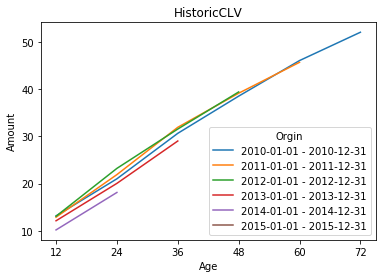

In [454]:
#Plot the graph for historic CLV
clv_data = hist_clv.copy(deep=True)
clv_data = clv_data.replace({'':None})
clv_data = clv_data.set_index('Orgin')
clv_data = clv_data.transpose()
clv_data.plot()
plt.title('HistoricCLV')
plt.xlabel('Age')
plt.ylabel('Amount')
plt.gca().set_xticklabels([0,12,24,36,48,60,72])
plt.show()


## Weighted Average of Historic CLV

In [440]:
#Weighted Average of historicCLV
#Historic CLV based on Age group * Number of customers in the segment/total number of customers in that age group(from all segments)
#--Numerator is equal to the cumulative transaction amount for each group
cus = customer.copy(deep=True)
cus =cus.replace({'':0})
amt1 = amount.copy(deep=True)
amt1 = amt1.replace({'':0})

w_12 = round(amt1['12'].sum()/cus['12'].sum(),2)
w_24 = round(amt1['24'].sum()/cus['24'].sum(),2)
w_36 = round(amt1['36'].sum()/cus['36'].sum(),2)
w_48 = round(amt1['48'].sum()/cus['48'].sum(),2)
w_60 = round(amt1['60'].sum()/cus['60'].sum(),2)
w_72 = round(amt1['72'].sum()/cus['72'].sum(),2)
w_hist_clv =pd.DataFrame({'Age':[12,24,36,48,60,72],
              'HistoricCLV' :
[w_12,w_24,w_36,w_48,w_60,w_72]})
w_hist_clv

,Age,HistoricCLV
0,12,12.50
1,24,21.42
2,36,30.77
3,48,39.05
4,60,45.93
5,72,52.12


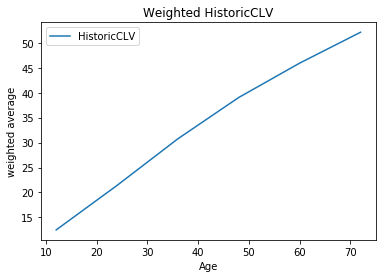

In [461]:
# Plot the graph
fin_plot = w_hist_clv.copy(deep=True)
fin_plot = fin_plot.set_index('Age')
#fin_plot = fin_plot.transpose()
fin_plot.plot()
plt.title('Weighted HistoricCLV')
plt.xlabel('Age')
plt.ylabel('weighted average')
plt.show()

# Step 7: Interpreting your results
##### 1. How much have customers acquired in 2011 spent to date?
$ 7821.67

##### 2. Do each group of customers exhibit similar or different patterns of spending? What’s the implication for the business?
From the graph we can say that regardless of the orgin, the transaction amount spent by the customer groups seems to follow a similar trend. Also, the customers are consistengly spending more amount with time. The business implication is that it should 
continue to get revenue from its customer if it consistantly follows the current operation.
Also the firm should strategize to retain its customerbase. From the postive trend in the graph we can infer that the current marketing strategy seems to effective and all the acquired customer seems to maintain a good transaction history. Perhaps the company should strategize acquiring more customer to maximize their profit marging.